In [1]:
!pip install bigframes -q


In [2]:
from google.cloud import bigquery

import bigframes.pandas as bpd
from bigframes.ml.linear_model import LinearRegression as BQLinearRegression

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression as SKLinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import pandas as pd
import matplotlib.pyplot as plt
sns.set_theme(color_codes=True)

In [3]:
PROJECT_ID = "arctic-eye-446816-j7"
REGION = "US"

In [4]:
bpd.options.bigquery.project = PROJECT_ID
bpd.options.bigquery.location = REGION

In [5]:
df2 = bpd.read_gbq("bigquery-public-data.chicago_crime.crime")
df2.head()

,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,3809715,HL151847,2005-01-29 23:30:00+00:00,014XX W MORSE AVE,2027,NARCOTICS,POSS: CRACK,SIDEWALK,True,False,...,49,1,18,1165420.0,1946171.0,2005,2018-02-28 15:56:25+00:00,42.007892,-87.666728,"(42.007891504, -87.666727525)"
1,7873610,HT104508,2011-01-04 00:30:00+00:00,046XX S EVANS AVE,2820,OTHER OFFENSE,TELEPHONE THREAT,RESIDENCE,False,True,...,4,38,26,1182034.0,1874483.0,2011,2016-02-04 06:33:39+00:00,41.810806,-87.607833,"(41.810806172, -87.607832602)"
2,12421979,JE299751,2021-06-14 19:00:00+00:00,055XX S STATE ST,0810,THEFT,OVER $500,RESTAURANT,False,False,...,3,40,06,1177220.0,1868236.0,2021,2021-07-15 15:39:41+00:00,41.793774,-87.625678,"(41.793773985, -87.625678392)"
3,8649560,HV324406,2012-06-08 08:00:00+00:00,027XX S DEARBORN ST,0890,THEFT,FROM BUILDING,PARK PROPERTY,False,False,...,3,35,06,1176315.0,1886573.0,2012,2016-02-04 06:33:39+00:00,41.844113,-87.628445,"(41.844112707, -87.628445336)"
4,1362379,G067268,2001-02-02 01:30:54+00:00,004XX N STATE ST,0460,BATTERY,SIMPLE,SMALL RETAIL STORE,True,False,...,<NA>,<NA>,08B,1176326.0,1903597.0,2001,2015-08-17 15:03:40+00:00,41.890827,-87.627892,"(41.890827398, -87.62789157)"


In [6]:
df3 = bpd.read_gbq("bigquery-public-data.austin_crime.crime")
df3.head()

,unique_key,address,census_tract,clearance_date,clearance_status,council_district_code,description,district,latitude,longitude,location,location_description,primary_type,timestamp,x_coordinate,y_coordinate,year,zipcode
0,20165026466,<NA>,23.13,2016-06-30 00:00:00+00:00,Not cleared,3,BURGLARY OF VEHICLE,H,<NA>,<NA>,(0 1 2 3 4...,2900 SUNRIDGE DR,Theft,2016-06-27 00:00:00+00:00,3119729,10053927,2016,78741
1,201440943,"119 FREDERICK ST Austin, TX 78704 (30.230732, ...",13.08,2014-01-08 00:00:00+00:00,Cleared by Arrest,3,BURGLARY OF RESIDENCE,D,30.230732,-97.760585,(0 1 2 ...,119 FREDERICK ST,Burglary / Breaking & Entering,2014-01-04 00:00:00+00:00,3108953,10057000,2014,78704
2,20151031435,<NA>,21.1,2015-04-22 00:00:00+00:00,Not cleared,1,BURGLARY NON RESIDENCE,C,<NA>,<NA>,(0 1 2 3 4...,4904 LOUIS AVE,Burglary,2015-04-13 00:00:00+00:00,3132451,10073733,2015,78721
3,20158003159,<NA>,19.01,2015-09-15 00:00:00+00:00,Not cleared,5,THEFT OF BICYCLE,D,<NA>,<NA>,(0 1 2 3 4...,1135 BARTON HILLS DR,Theft,2015-09-11 00:00:00+00:00,3104868,10068158,2015,78704
4,20145025710,"6200 LOYOLA LN Austin, TX 78724 (30.30171, -97...",22.02,2014-06-24 00:00:00+00:00,Not cleared,1,BURGLARY OF VEHICLE,C,30.30171,-97.651541,(0 1 2 ...,6200 LOYOLA LN,Theft: BOV,2014-06-10 00:00:00+00:00,3143028,10083917,2014,78724


In [7]:
df2.info()

<class 'bigframes.dataframe.DataFrame'>


Index: 8247404 entries, 0 to 8247403
Data columns (total 22 columns):
  #  Column                Dtype
---  --------------------  ------------------------------
  0  unique_key            Int64
  1  case_number           string
  2  date                  timestamp[us, tz=UTC][pyarrow]
  3  block                 string
  4  iucr                  string
  5  primary_type          string
  6  description           string
  7  location_description  string
  8  arrest                boolean
  9  domestic              boolean
 10  beat                  Int64
 11  district              Int64
 12  ward                  Int64
 13  community_area        Int64
 14  fbi_code              string
 15  x_coordinate          Float64
 16  y_coordinate          Float64
 17  year                  Int64
 18  updated_on            timestamp[us, tz=UTC][pyarrow]
 19  latitude              Float64
 20  longitude             Float64
 21  location              string
dtypes: Float64(4), Int64(6), boolean(2), s

memory usage: 1402058680 bytes


In [8]:
df3.info()

<class 'bigframes.dataframe.DataFrame'>


Index: 116672 entries, 0 to 116671
Data columns (total 18 columns):


/opt/conda/lib/python3.10/site-packages/bigframes/core/blocks.py:125: NullIndexPreviewWarning: Creating object with Null Index. Null Index is a preview feature.
  warnings.warn(


  #  Column                 Non-Null Count    Dtype
---  ---------------------  ----------------  ------------------------------
  0  unique_key             116671 non-null   Int64
  1  address                40640 non-null    string
  2  census_tract           116149 non-null   Float64
  3  clearance_date         111558 non-null   timestamp[us, tz=UTC][pyarrow]
  4  clearance_status       111558 non-null   string
  5  council_district_code  115997 non-null   Int64
  6  description            116672 non-null   string
  7  district               116672 non-null   string
  8  latitude               34500 non-null    Float64
  9  longitude              34500 non-null    Float64
 10  location               116672 non-null   string
 11  location_description   116672 non-null   string
 12  primary_type           116672 non-null   string
 13  timestamp              116672 non-null   timestamp[us, tz=UTC][pyarrow]
 14  x_coordinate           114525 non-null   Int64
 15  y_coordinate           

memory usage: 17734144 bytes


In [9]:
df2['district'].head()

0    24
1     2
2     2
3     1
4    18
Name: district, dtype: Int64

In [10]:
chicago_df = df2[['date','year','primary_type','arrest']].reset_index()

In [11]:
austin_df = df3[['timestamp','year','primary_type','clearance_status']].reset_index()

In [12]:
for df in [chicago_df, austin_df]:
    for column in df.columns:
        print(f'{column} unique values: {len(df[column].unique())}')

index unique values: 8247404


date unique values: 3432017


year unique values: 25


primary_type unique values: 36


arrest unique values: 2


index unique values: 116672


timestamp unique values: 1096


year unique values: 3


primary_type unique values: 18


clearance_status unique values: 4


In [13]:
austin_df.clearance_status.unique()

0              Not cleared
1        Cleared by Arrest
24    Cleared by Exception
34                    <NA>
Name: clearance_status, dtype: string

In [14]:
import numpy as np
austin_df['arrest'] = np.where(austin_df['clearance_status'] == 'Cleared by Arrest', np.where(austin_df['clearance_status'] == 'Cleared by Exception', True, True), False)


In [15]:
austin_df = austin_df.drop(columns='clearance_status')


In [16]:
austin_df = austin_df.rename(columns = {'timestamp':'date'})
austin_df.info()

<class 'bigframes.dataframe.DataFrame'>


Index: 116672 entries, 0 to 116671
Data columns (total 5 columns):


/opt/conda/lib/python3.10/site-packages/bigframes/core/blocks.py:125: NullIndexPreviewWarning: Creating object with Null Index. Null Index is a preview feature.
  warnings.warn(


  #  Column        Non-Null Count    Dtype
---  ------------  ----------------  ------------------------------
  0  index         116672 non-null   Int64
  1  date          116672 non-null   timestamp[us, tz=UTC][pyarrow]
  2  year          116672 non-null   Int64
  3  primary_type  116672 non-null   string
  4  arrest        116672 non-null   boolean
dtypes: Int64(2), boolean(1), string(1), timestamp[us, tz=UTC][pyarrow](1)


memory usage: 4783552 bytes


In [17]:
chicago_df.info()

<class 'bigframes.dataframe.DataFrame'>


Index: 8247404 entries, 0 to 8247403
Data columns (total 5 columns):
  #  Column        Dtype
---  ------------  ------------------------------
  0  index         Int64
  1  date          timestamp[us, tz=UTC][pyarrow]
  2  year          Int64
  3  primary_type  string
  4  arrest        boolean
dtypes: Int64(2), boolean(1), string(1), timestamp[us, tz=UTC][pyarrow](1)


memory usage: 338143564 bytes


In [21]:
chicago_group = chicago_df[['year', 'arrest']].groupby(['year']).count()


,arrest
year,
2001,485931
2002,486827
2003,475990
2004,469433
2005,453779
2006,448193
2007,437098
2008,427201
2009,392851


In [27]:
chicago_group = chicago_group.reset_index()
chicago_group

,year,arrest
0,2001,485931
1,2002,486827
2,2003,475990
3,2004,469433
4,2005,453779
5,2006,448193
6,2007,437098
7,2008,427201
8,2009,392851
9,2010,370546


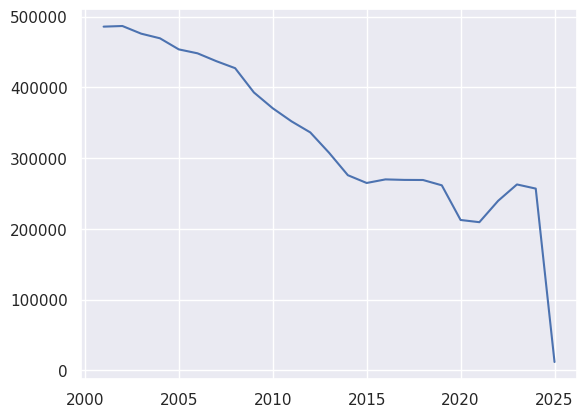

In [30]:
plt.plot(chicago_group.year, chicago_group.arrest)
plt.show()

In [32]:
austin_df.year.unique()

0    2016
1    2014
2    2015
Name: year, dtype: Int64

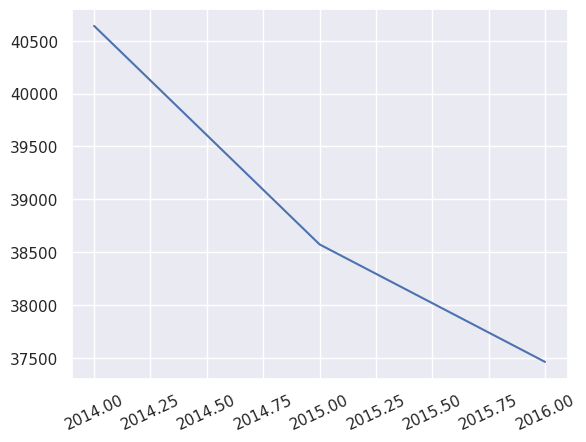

In [33]:
austin_group = austin_df[['year', 'arrest']].groupby(['year']).count().reset_index()
plt.plot(austin_group.year, austin_group.arrest)
plt.xticks(rotation = 25)
plt.show()
